<a href="https://colab.research.google.com/github/clemsage/NeuralDocumentClassification/blob/master/skeleton_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Training a classifier on OCR text input


# Imports & Cloning repository


In [2]:
import os
import pickle
import sys
from dataclasses import dataclass
from os import path

import matplotlib.pyplot as plt
import tqdm


In [3]:
class_names = ["email", "form", "handwritten", "invoice", "advertisement"]
NUM_CLASSES = len(class_names)

In [3]:
if not os.path.exists("NeuralDocumentClassification"):
    !git clone https://github.com/thibaultdouzon/NeuralDocumentClassification.git
else:
    !git -C NeuralDocumentClassification pull
sys.path.append("NeuralDocumentClassification")

error: cannot pull with rebase: You have unstaged changes.
error: Please commit or stash them.


In [4]:
from src import download_dataset

dataset_path = "dataset"

download_dataset.download_and_extract("all", dataset_path)

In [5]:
with open(path.join(dataset_path, "train.pkl"), "rb") as f:
    train_dataset = pickle.load(f)

with open(path.join(dataset_path, "test.pkl"), "rb") as f:
    test_dataset = pickle.load(f)

with open(path.join(dataset_path, "validation.pkl"), "rb") as f:
    validation_dataset = pickle.load(f)


for split_name, split_dataset in zip(
    ["train", "test", "validation"], [train_dataset, test_dataset, validation_dataset]
):
    print(f"{split_name}_dataset contains {len(split_dataset)} documents")
train_dataset[0].keys()


train_dataset contains 5000 documents
test_dataset contains 1000 documents
validation_dataset contains 500 documents


dict_keys(['id', 'image', 'label', 'words', 'boxes'])

Each `dataset` object is a `list` containing multiple document information. A document is a `dict` with the following structure:

```json
{
  "id": "Unique document identifier",
  "image": "A PIL.Image object containing the document's image",
  "label": "A number between in [0 .. 4] representing the class of the document",
  "words": "A list of strings (not words !) extracted from the image with an OCR",
  "boxes": "A list of tuples of numbers providing the position of each word in the document"
}
```


# Explore the data

Take the time to explore the textual data included in the dataset.


Ideas

- 10 most common words? (hint: Counter)
- Count number of unique words
- Distribution of words (cumulative occurences plot)


In [22]:
# @title

from collections import Counter

all_texts = [
    [word for sentence in doc["words"] for word in sentence.split()]
    for doc in validation_dataset + test_dataset + train_dataset
]

most_common_words = Counter([w for text in all_texts for w in text])
most_common_words.most_common(10)

[('1', 12422),
 ('the', 6477),
 ('and', 4232),
 ('8', 4030),
 ('of', 3798),
 ('3', 3053),
 ('2', 2958),
 (',', 2832),
 ('to', 2529),
 ('0', 2507)]

In [23]:
# @title

n_unique_words = len({w for text in all_texts for w in text})
n_unique_words

277083

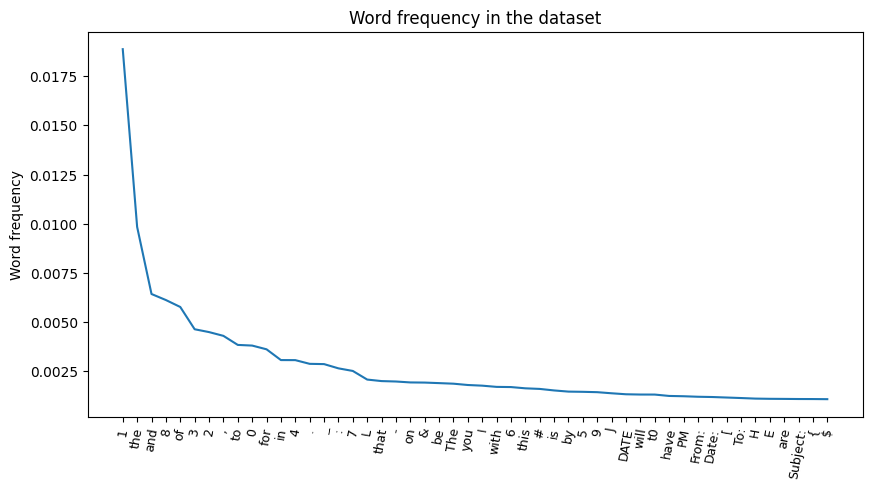

In [34]:
# @title

# Zipf's law

plt.figure(figsize=(10, 5))
plt.plot(
    [c / sum(most_common_words.values()) for w, c in most_common_words.most_common(50)]
)

# put words on xlabel
plt.xticks(
    range(50),
    [w for w, c in most_common_words.most_common(50)],
    rotation=80,
    fontsize=9,
)
plt.ylabel("Word frequency")
plt.title("Word frequency in the dataset")
plt.show()

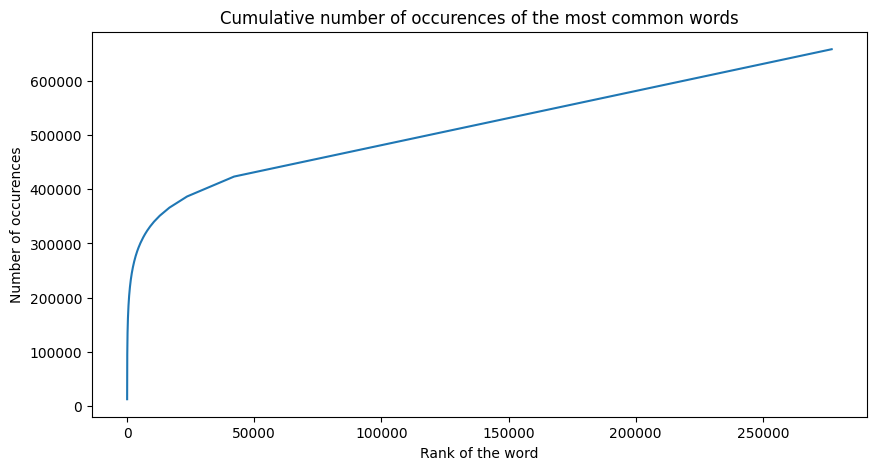

In [24]:
# @title
from itertools import accumulate

cum_word_occurences = list(
    accumulate([count for word, count in most_common_words.most_common(n_unique_words)])
)

plt.figure(figsize=(10, 5))
plt.plot(cum_word_occurences)

plt.xlabel("Rank of the word")
plt.ylabel("Number of occurences")
plt.title("Cumulative number of occurences of the most common words")
plt.show()

# Classification with Scikit Learn


In [6]:
import nltk
import sklearn


@dataclass
class TextSample:
    text: str
    label: int

    def __init__(self, document: dict):
        self.text = " ".join(
            [word for sentence in document["words"] for word in sentence.split()]
        )
        self.label = document["label"]


train_samples = [TextSample(doc) for doc in train_dataset]

test_samples = [TextSample(doc) for doc in test_dataset]

validation_samples = [TextSample(doc) for doc in validation_dataset]


## Tokenization and Vectorization

To train models at solving our problem, we need to convert texts into vectors that will represent our documents.
Take a look at Scikit Learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#) and [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
First fit a vectorizer on the training set, then apply the vectorization transformation to each dataset split.

What are the shapes of the resulting vectors? What does each dimension mean?


In [7]:
# @title

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform([sample.text for sample in train_samples])
X_test = vectorizer.transform([sample.text for sample in test_samples])
X_validation = vectorizer.transform([sample.text for sample in validation_samples])

Y_train = [sample.label for sample in train_samples]
Y_test = [sample.label for sample in test_samples]
Y_validation = [sample.label for sample in validation_samples]


X_train.shape, X_test.shape, X_validation.shape
# Each vector's first dimension is the number of documents, the second dimension is the number of unique words in the dataset
# The value at (i, j) is the number of occurences of the j-th word in the i-th document

((5000, 154306), (1000, 154306), (500, 154306))

## Basic Model: Scikit-Learn Classification

Use any Scikit-Learn classification model to train a first text model.
Good first picks: [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) or [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


SVC(kernel='linear')

In [ ]:
# @title

from sklearn.svm import SVC

model = SVC(kernel="linear")
model.fit(X_train, Y_train)


## Evaluate the model

Use Scikit-Learn [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) to evaluate your model


In [11]:
# @title

from sklearn.metrics import accuracy_score, confusion_matrix

print("Test")
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")
print(confusion_matrix(Y_test, Y_pred))

print("Validation")
Y_pred = model.predict(X_validation)
accuracy = accuracy_score(Y_validation, Y_pred)
print(f"Accuracy on the validation set: {accuracy:.2f}")
print(confusion_matrix(Y_validation, Y_pred))


Test
Accuracy on the test set: 0.75
[[186   6   0   1   5]
 [  8 159  14  17  13]
 [  4  10 111  24  53]
 [  4  24  14 137  10]
 [  3   8  18  16 155]]
Validation
Accuracy on the validation set: 0.75
[[99  3  1  0  2]
 [ 2 83  6  7 12]
 [ 3 13 45 12 32]
 [ 1 11  4 66  6]
 [ 3  3  4  2 80]]


# Transformers

Done playing with kids toys.

All modern AI models use the [Transformer architecture](https://arxiv.org/pdf/1706.03762). The initial research paper is one of the most influencial of the last decade.


In [13]:
import transformers

## Tokenization

Transformers usually use subword tokenizer, ie. a word _can_ be tokenized into multiple tokens.


In [17]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "microsoft/layoutlm-base-uncased"
)

tokenizer_config.json:   0%|          | 0.00/170 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/Users/thibaultdouzon/Code/NeuralDocumentClassification/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
encoding = tokenizer("Hello, world! I can tokenize any sentence.")

for token_id in encoding["input_ids"]:
    print(tokenizer.decode(token_id))


[CLS]
hello
,
world
!
i
can
token
##ize
any
sentence
.
[SEP]
